In [1]:
import os
import math

import torch
import numpy as np
from PIL import Image, ImageDraw

from scorefield.models.ddpm.denoising_diffusion import Unet
from scorefield.models.heat.heat_diffusion import GaussHeatDiffusion, HeatDiffusion_Revised
from scorefield.models.rrt.rrt import RRTStar
from scorefield.utils.rl_utils import load_config
from scorefield.utils.utils import (
    gen_goals, overlay_goal, overlay_multiple, combine_objects, overlay_images,
    overlay_goal_agent, overlay_goals_agent, log_num_check,
    draw_obstacles_pil, convert_to_obstacle_masks,

    randgen_obstacle_masks, draw_obstacles_pixel,
    vector_field, clip_vectors
)

import matplotlib.pyplot as plt

import imageio
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff



# Args
config_dir = "./scorefield/configs/heat_diffusion.yaml"

args = load_config(config_dir)
device = args['device']

bg = Image.open('assets/toy_exp/background0.png').convert('RGBA')
wastes = []
wastes.append(Image.open('assets/toy_exp/waste0.png'))
# wastes.append(Image.open('assets/toy_exp/waste4.png'))
# wastes.append(Image.open('assets/toy_exp/waste5.png'))


img_size = args['image_size']
goal_bounds = args['goal_bounds']
goal_num = len(wastes)
agent_bounds = args['agent_bounds']
obstacle_pos = args['obstacles']


noise_steps = args['noise_steps']
u0 = args['u0']
min_heat_step = args['min_heat_step']
max_heat_step = args['max_heat_step']
sample_num = args['sample_num']
time_type = args['time_type']
noise_steps = args['noise_steps']

diffusion = HeatDiffusion_Revised(
    image_size=img_size,
    u0 = u0,
    noise_steps=noise_steps,
    min_heat_step=min_heat_step,
    max_heat_step=max_heat_step,
    time_type=time_type,
    device=device,
)

gauss_diffusion = GaussHeatDiffusion(
    image_size=img_size,
    u0 = u0,
    noise_steps=noise_steps,
    min_heat_step=min_heat_step,
    max_heat_step=max_heat_step,
    time_type=time_type,
    device=device,
)


/home/mlcs_edf/mambaforge/envs/diffusion/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


dt:tensor([   50,   128,   288,   578,  1058,  1922,  3200,  5408,  8978, 14450],
       device='cuda:0')
heat kernel std:tensor([ 5.,  8., 12., 17., 23., 31., 32., 32., 32., 32.], device='cuda:0')
dt:tensor([   50,   128,   288,   578,  1058,  1922,  3200,  5408,  8978, 14450],
       device='cuda:0')
heat kernel std:tensor([ 5.,  8., 12., 17., 23., 31., 32., 32., 32., 32.], device='cuda:0')


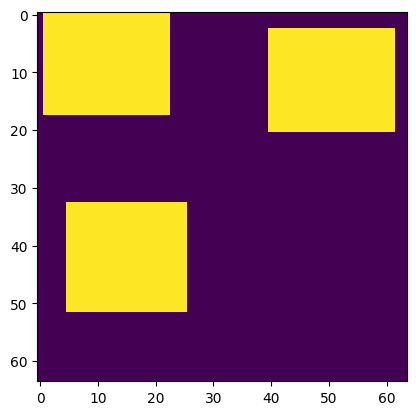

In [2]:
obstacle_masks = randgen_obstacle_masks(1, img_size)
background = draw_obstacles_pixel(bg, obstacle_masks)

obstacle_masks = obstacle_masks[0].unsqueeze(0)

plt.imshow(obstacle_masks[0].cpu().numpy())
plt.show()

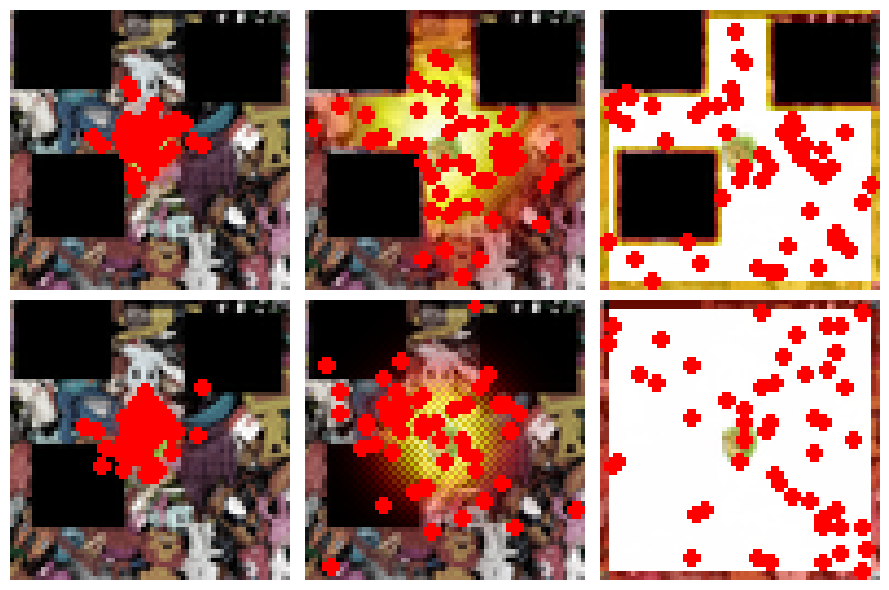

In [5]:
goal = torch.tensor([[[-0.,-0.]]], device=device)
obs = overlay_goal(background, img_size, wastes, goal)
t = torch.tensor([i for i in range(1, noise_steps+1)], device=device)

heat, _, _, x_t = diffusion.forward_diffusion(t, goal.repeat(10,1,1), 50, obstacle_masks.repeat(10,1,1))
heat2, x_t2 = gauss_diffusion.forward_diffusion(t, goal.repeat(10,1,1), 50)

fig, axes = plt.subplots(2, 3, figsize=(9,6))

col1 = 0
col2 = 0
for i in range(noise_steps):
    if i == 0 or i==3 or i==9:
        norm_data = (heat[i]-torch.min(heat[i])) / (torch.max(heat[i]) - torch.min(heat[i]))
        norm_data = norm_data.cpu().detach().numpy()
        rgb_data = (plt.cm.hot(norm_data)[:, :, :3]*255).astype(np.uint8)
        rgba_data = np.zeros((norm_data.shape[0], norm_data.shape[1], 4), dtype=np.uint8)
        rgba_data[...,:3] = rgb_data
        rgba_data[...,3] = (norm_data*255).astype(np.uint8)
        heat_img = Image.fromarray(rgba_data, 'RGBA')
        heat_resized = heat_img.resize(background[0].size)
        composite_img = Image.alpha_composite(background[0], heat_resized)
        final_img = overlay_goal_agent([composite_img], wastes, goal.cpu(), x_t[i].unsqueeze(0).cpu(), 1.2)
        axes[0,col1].imshow(final_img[0])
        axes[0,col1].axis('off')
        col1+=1
       
    if i == 0 or i==2 or i==9: 
        norm_data2 = (heat2[i]-torch.min(heat2[i])) / (torch.max(heat2[i]) - torch.min(heat2[i]))
        norm_data2 = norm_data2.cpu().detach().numpy()
        rgb_data2 = (plt.cm.hot(norm_data2)[:,:,:3]*255).astype(np.uint8)
        rgba_data2 = np.zeros((norm_data2.shape[0], norm_data2.shape[1], 4), dtype=np.uint8)
        rgba_data2[...,:3] = rgb_data2
        rgba_data2[...,3] = (norm_data2*255).astype(np.uint8)
        heat_img2 = Image.fromarray(rgba_data2, 'RGBA')
        heat_resized2 = heat_img2.resize(background[0].size)
        composite_img2 = Image.alpha_composite(background[0], heat_resized2)
        final_img2 = overlay_goal_agent([composite_img2], wastes, goal.cpu(), x_t2[i].unsqueeze(0).cpu(), 1.2)
        axes[1,col2].imshow(final_img2[0])
        axes[1,col2].axis('off')
        col2+=1
        

plt.tight_layout()
plt.show()

In [10]:
x_t.shape

torch.Size([10, 50, 2])